# Trajectories data-mining

In [3]:
import pandas as pd
import numpy as np
import json
import matplotlib.cm as colormap
import folium
from sklearn.cluster import DBSCAN
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

 # Get your google takeout data
 You may annalyze your own google take out data by requesting an export of your location history here : https://takeout.google.com/settings/takeout. You will get a zip file that you may extract in your working folder and read with the following code. In case you didn't have a location history (if you have descativated localisation on your phone or if you have an iphone) a sample file is provided. We will use dbscan for several tasks :

- find the hot-spot in the localisation such as residence, home, ...
- segment displacements into trips 
- find recurrent trips with similar origines and destinations

Take time to read carrefully this notebook and read the documentation of the funcions that i used from pandas, numpy, folium or pyproj if needed. 

- [numpy](https://numpy.org/learn/)
- [pandas](https://pandas.pydata.org/docs/)
- [sklearn](https://scikit-learn.org/stable/)
- [folium](https://python-visualization.github.io/folium/modules.html)
- [pyproj](https://pyproj4.github.io/pyproj/stable/)


In [9]:
# read the json data
json_string=open("./Takeout/Historique des positions/Historique des positions.json").read()
# get the location data and convert to pandas df
locations=pd.DataFrame(json.loads(json_string)["locations"])
# a quick look
locations

,timestampMs,latitudeE7,longitudeE7,accuracy,activity,velocity,heading,altitude,verticalAccuracy
521748,1483234855337,488928230,27940052,48,"[{'timestampMs': '1483234842318', 'activity': ...",None,None,None,None
521749,1483252470419,488929587,27947125,192,None,None,None,None,None
521750,1483252906458,488926451,27940491,48,"[{'timestampMs': '1483253428663', 'activity': ...",None,None,None,None
521751,1483254005344,488928117,27938772,64,"[{'timestampMs': '1483263223729', 'activity': ...",None,None,None,None
521752,1483264048885,488928976,27939193,25,"[{'timestampMs': '1483264175170', 'activity': ...",None,None,None,None
...,...,...,...,...,...,...,...,...,...
681684,1514671792371,474030200,9548574,542,"[{'timestampMs': '1514671739135', 'activity': ...",None,None,None,None
681685,1514671914791,474030200,9548574,725,None,None,None,None,None
681686,1514672048709,474030200,9548574,926,"[{'timestampMs': '1514671987917', 'activity': ...",None,None,None,None
681687,1514745072433,474028661,9548851,20,"[{'timestampMs': '1514672087350', 'activity': ...",None,None,None,None


### Pre - processing

We start by creating some additional features. Month, time difference between two location measurements, distance between two successive location measurements and speed in km/h. To compute the distances in km, we will first define a function to compute it from latitude and longitudes pairs.

In [10]:
import math

def distance(lat1, long1, lat2, long2):

    # Convert latitude and longitude to 
    # spherical coordinates in radians.
    degrees_to_radians = math.pi/180.0
        
    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
        
    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians
        
    # Compute spherical distance from spherical coordinates.
        
    # For two locations in spherical coordinates 
    # (1, theta, phi) and (1, theta, phi)
    # cosine( arc length ) = 
    #    sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length
    
    cos = (np.sin(phi1)*np.sin(phi2)*np.cos(theta1 - theta2) + 
           np.cos(phi1)*np.cos(phi2))
    cos[cos<-1]=-1
    cos[cos>1]=1
    arc = np.arccos( cos )

    # Remember to multiply arc by the radius of the earth 
    # in your favorite set of units to get length.
    return arc*6378

In [11]:
locations = locations.loc[locations["accuracy"]<250,:].copy()
locations["time"] = pd.to_datetime(locations["timestampMs"],unit="ms")
locations["timestampMs"]=np.array(locations["timestampMs"],dtype='int64')
locations["monthyear"]=locations["time"].apply(lambda d:d.strftime("%m/%Y"))
locations["latitude"]=locations["latitudeE7"]/10000000
locations["longitude"]=locations["longitudeE7"]/10000000
locations["delta_t"]=(locations["timestampMs"]-locations["timestampMs"].shift(1))/(1000*60*60)
locations["dist"] = distance(locations["latitude"],locations["longitude"],locations["latitude"].shift(1),locations["longitude"].shift(1))
locations["speed"] = locations["dist"]/locations["delta_t"]
locations = locations.loc[locations["speed"]<150,:].copy()

### Select a sample of ~ 10000 localisations
If your location history is too big select a sample of around 10000 points. With the provided dataset it will approximativly correspond to two month of data. 

### A quick look at speeds 
We will look at the histogram of the speed and create a boolean feature to indicate when points corresponds to displacements (by threesholdings the speed).

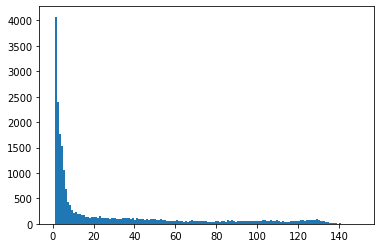

In [12]:
h=plt.hist(locations["speed"][(locations["speed"]<150) & (locations["speed"]>1)],150)

In [13]:
np.mean(locations["speed"])

10.82563754037202

In [14]:
locations["displacement"]=locations["speed"]>2

### Data exploration with an interactive map

We will use folium a python library to create interactive webmaps. Note the use of the opacity of the point to show the points accumulation. Change the map center and scale for your data if needed.

In [8]:
m = folium.Map(
    location=[48.83, 2.58],
    tiles='Stamen Toner',
    zoom_start=10
)

In [9]:
for i,p in locations.loc[~locations["displacement"]].sample(3000).iterrows():
    folium.Circle(
        radius=100,
        location=[p["latitude"], p["longitude"]],
        popup=p["time"],
        color='crimson',
        fill='crimson',
        opacity=0.1
    ).add_to(m)


In [10]:
m

# Geographical projection. 
We use pyproj to project the locatins with the french official projection, you may change if your locations are not in france . This will get us localization with position in meters and help us to define the radius used by DBSCAN.

In [11]:
Xstatic = locations.loc[(~locations["displacement"]) & (locations["dist"]>0),:].sample(20000)

In [12]:
from pyproj import Proj, transform
outProj = Proj('epsg:2154')
inProj = Proj('epsg:4326')
x,y = transform(inProj,outProj,Xstatic["latitude"].values,Xstatic["longitude"].values)
Xp=np.transpose(np.vstack([x,y]))

<ipython-input-12-ecf833942cda>:4: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x,y = transform(inProj,outProj,Xstatic["latitude"].values,Xstatic["longitude"].values)


# Extract frequent visited places (hot-spot) with dbscan

- create a dbscan clustering (called db) with sklearn and try to find good values for the parameters (remember data are in meters)
- use it to process your data (keeping only those which correspond to static points) i.e. the Xp array 
- how many cluster have you found ?
- you may use the following code to explore the results with an interactive map

In [13]:
#pour convertir une colueur au foramt hexa
def tohex(col):
    rgb = tuple(int(v*255) for v in col[:3])
    return u"#{0:02x}{1:02x}{2:02x}".format(rgb[0],rgb[1],rgb[2])



In [ ]:
mdbs = folium.Map(
    location=[48.83, 2.58],
    tiles='Stamen Toner',
    zoom_start=10
)
for l in range(db.labels_.max()):
    center = Xstatic.loc[db.labels_==l,["latitude","longitude"]].mean()
    ts = Xstatic.loc[db.labels_==l,"timestampMs"].apply(lambda v: int(v)/1000)
    time_center = datetime.utcfromtimestamp(ts.mean()).strftime('%d/%m/%Y %H:%M:%S')
    time_min = datetime.utcfromtimestamp(ts.min()).strftime('%d/%m/%Y')
    time_max = datetime.utcfromtimestamp(ts.max()).strftime('%d/%m/%Y')
    folium.CircleMarker(
        radius= np.sqrt(float(np.sum(db.labels_==l)))/10,
        color = tohex(colormap.Set1(l/db.labels_.max())),
        fill_color = tohex(colormap.Set1(l/db.labels_.max())),
        fill_opacity = 0.2,
        popup = "<h4> Cluster "+ str(l) +"</h4>"+str(np.sum(db.labels_==l)) + " points,</br> au alentour du "+ time_center + "</br>sur la periode ["+ time_min+","+time_max +"]",
        location=center
    ).add_to(mdbs)
    

In [ ]:
mdbs

# Segment displacements into trips

We will create a data frame with only displacements points and create a time vector with their time stamps. Displacements will be separated by gaps where their is no displacements. We may use dbscan to find these gaps on the time feature and segments the displacements into trips

In [ ]:
# extract the relevant rows from our data
Xdisplacement =locations.loc[locations["displacement"] & (locations["accuracy"]<250),:].copy()
time_disp = (Xdisplacement["timestampMs"]-Xdisplacement["timestampMs"].min())/(1000*60*60)
# reshape to obtain an [nbpoints,1] matrix since dbscan wait for matrix and not vector
time_disp = time_disp.values.reshape(-1,1)
# use an histogram to display the time of measurement look at the gaps between the displacements
h=plt.hist(time_disp[time_disp[:,0]<96,0],96*4,range=(0,96))
xl = plt.xlim((0,96))

### Question

Create a dbtime instance of dbscan with reasonable parmaters, this time our time feature is in hour. 
How many cluster did you have ? you may use the following code to plot the results over the first 4 days.

Compute summary statisics of your trips: length, duration, mean speed and plot the corresponding histograms

tips : add a trip id featue in the Xdisplacement dataframe and use the groupby functionality of pandas.

In [ ]:
time_clust = [time_disp[(dbtime.labels_==l),:] for l in range(dbtime.labels_.max()+1)]
h=plt.hist(time_clust[:14],96*4,range=(0,96),stacked=True)
xl=plt.xlim((0,96))

In [ ]:
ph=plt.hist(trips_stats["dist"].values,90)

In [ ]:
ph=plt.hist(trips_stats["delta_t"].values,90)

In [ ]:
ph=plt.hist(trips_stats["speed"].values,90)

## Frequent trips
We will annalyze the trips by looking at frequent trips in the dataset.
### Questions
Extract the first and last points of each trips to define the origine and destination of each trips. Build a matrix of 4 features : x_origine,y_origine,x_destination, y_destination by projecting the origines and destinations points of the trips and stacking thme into a numpy array. Use a last time dbscan to extract frequent trips. Then you may used the folium code to look at the results.

tips : use the last and first function from pandas

In [ ]:
my_map = folium.Map(
    location=[48.83, 2.58],
    tiles='cartodbpositron',
    zoom_start=11
)
for l in range(dbod.labels_.max()+1):
    ori = origines.loc[dbod.labels_==l,["latitude","longitude"]].mean()
    dest = destinations.loc[dbod.labels_==l,["latitude","longitude"]].mean()
    folium.PolyLine(np.vstack([ori,dest]), color="red", weight=2.5, opacity=1).add_to(my_map)

In [ ]:
my_map